## Well ties and wavelet estimation methods

The aim of this notebook is to illustrate a number of wavelet estimation methods regularly, or not so regularly used in seismic interpretation and well ties. 

We look at four approaches of estimating a wavelet for making a synthetic 

1. Eyeballing a Ricker Wavelet from seismic's frequency content

2. Autocorrelation 

3. Spectral divison method 

4. Wiener filtering

Lastly we evaluate the quality of these wavelets in regards to their fittedness to the observed seismic data

Things to consider / do / include

* Pearson's correlation coefficient

* Showing difference plot

* RMS error of data-synthetic

In [1]:
import numpy as  np
from numpy.linalg import lstsq
from scipy import fft, ifft
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from bruges.filters import ricker

% matplotlib inline

# Get data

In [2]:
#Get seismic data
from obspy.segy.segy import readSEGY

# Copied verbatim from Seisplot


def get_seismic(target):
    # Read the file.
    section = readSEGY(target, unpack_headers=True)

    # Calculate some things.
    # NB Getting nsamples and dt from the first trace assumes that all
    # traces are the same length, which is not a safe assumption in SEGY v2.
    nsamples = section.traces[0].header.number_of_samples_in_this_trace
    dt = section.traces[0].header.sample_interval_in_ms_for_this_trace
    ntraces = len(section.traces)
    tbase = 0.001 * np.arange(0, nsamples * dt, dt)
    tstart = 0
    tend = np.amax(tbase)

    # Make the data array.
    data = np.vstack([t.data for t in section.traces]).T

    # Collect some other data. Use a for loop because there are several.
    elev, esp, ens, tsq = [], [], [], []
    for i, trace in enumerate(section.traces):
        elev.append(trace.header.receiver_group_elevation)
        esp.append(trace.header.energy_source_point_number)
        ens.append(trace.header.ensemble_number)
        tsq.append(trace.header.trace_sequence_number_within_line)
    clip_val = np.percentile(data, 98)
    
    return data


Get data from a single crossline that I exported from OpendTect.

In [3]:
data = get_seismic('data/XL_1153_Penobscot.segy')

Define some variables

In [155]:
dt = 4000/1e6 # sample rate in seconds
x = 100 # trace position of the well along the line
s = data[:,x]
m = np.loadtxt('data/synth_25hz.txt')
ip = np.nan_to_num(np.loadtxt('data/ip.txt'))
r = np.nan_to_num(np.loadtxt('data/RC_t.txt'))
t_r = np.loadtxt('data/tbaseRC.txt')

In [156]:
def norm(data):
    return data/np.amax(data)

## Show the well

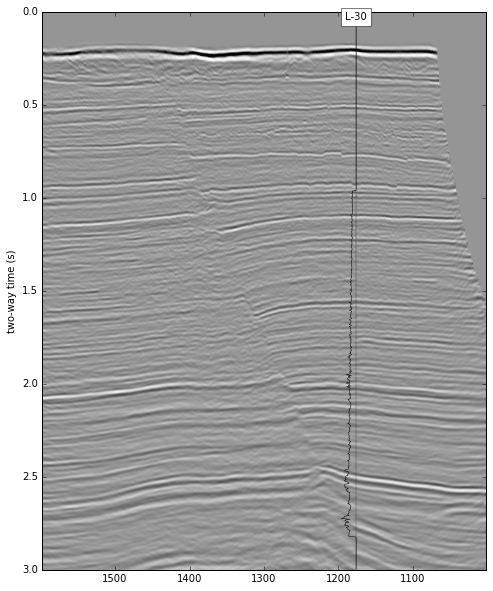

In [157]:
gain_imp=20
well_name='L-30'
ilx = 1176

xlrange = (1598,1001)
x =  ilx - xlrange[1]

tstart, tstop = 0, 3.0 # 0-3 second
tidx1, tidx2 = 0, 750  #(0 to 3 seconds)
aspect = 250.0

# make figure
plt.figure(figsize=(10,10))

# plot seismic
plt.imshow(norm(data)[tidx1:tidx2,:], cmap='Greys', aspect=aspect, clim=(-0.5,0.5), 
           extent=[xlrange[1],xlrange[0],tstop,tstart])
# plot well
plt.axvline(ilx,color='k',lw=0.25)
plt.plot(gain_imp*(norm(ip[1:]))+ilx, t_r,'k',lw=0.5)
plt.text(ilx,0,s=well_name,ha='center', va='top',
         bbox=dict(facecolor='white', alpha=1.0, lw = 0.5)
         )
# annotation
plt.gca().set_xlim((xlrange[1],xlrange[0]))
plt.gca().set_ylim((tstop,tstart))
plt.gca().invert_xaxis()
plt.ylabel('two-way time (s)')

In [158]:
data.shape

(1501, 601)

In [159]:
lateral_shift = 0 # choose a neighbouring trace if you want too
seis_line = norm(data)[tidx1:tidx2,:]
well_trace = seis_line[:,x+lateral_shift]
s = well_trace

In [160]:
# other data
dt = 0.004  # sample rate (seconds)
t = np.arange(0, len(s)*dt, dt)
log_start = 0.4105 # start time of log

In [161]:
t.shape

(750,)

In [162]:
seis_line.shape

(750, 601)

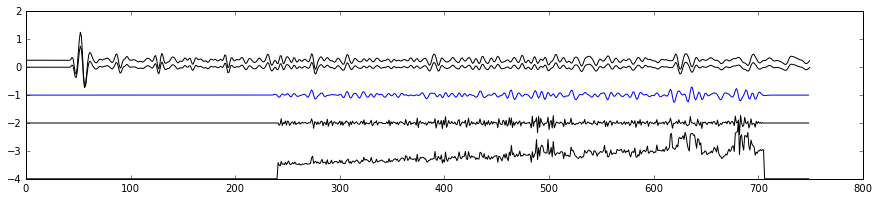

In [163]:
plt.figure(figsize=(15,3))
plt.plot(t/dt, s,'k')      # close by trace
plt.plot(t/dt, 0.25 + norm(s), 'k') # seismic trace
plt.plot(t_r/dt, -1 + m, 'b') # synthetic
plt.plot(t_r/dt, -2 + r, 'k') # reflectivity
plt.plot(t_r/dt, -4 + ip[1:]/1e7, 'k') # impedance

# Wavelet estimation by visual inspection

In [164]:
# plot params
ms = 4 # markersize

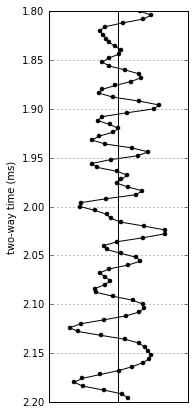

In [165]:
aa, bb = 450, 550

plt.figure(figsize=(2.5,7))
plt.plot(norm(s[aa:bb]),t[aa:bb],'ko-', ms=ms)
plt.axvline(0,color='k')

plt.gca().set_xlim(-1.5,1.5)
plt.gca().invert_yaxis()
plt.gca().set_xticks([])
plt.ylabel('two-way time (ms)')
plt.grid()

# Make a Ricker wavelet

In [166]:
duration = 0.256 # seconds
freq = 20.0 # frequeny
w1 = ricker(duration, dt, freq)
tw = np.arange(-len(w1)//2,len(w1)//2,1)*dt

# Plot wavelet along side data

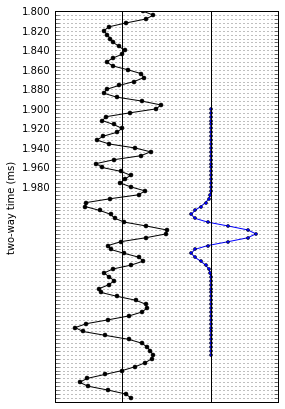

In [167]:
buff = 2
plt.figure(figsize=(4,7))

# plot segment of trace
plt.plot(norm(s[aa:bb]),t[aa:bb],'ko-', ms=ms)
plt.axvline(0,color='k')

# plot segment of wavelet
bksf = 25
plt.plot(buff + w1, t[aa+bksf:aa+bksf+len(w1)], 'bo-', ms='3')
plt.axvline(0+buff,color='k')

plt.gca().set_xlim(-1.5,buff+1.5)
plt.gca().invert_yaxis()
plt.gca().set_yticks(np.arange(1.80,2.20,0.004))

# There's gotta be a better way to do these ytick label
# Major and minor ticks?
plt.gca().set_yticklabels(['1.800','','','','','1.820',
                           '','','','','1.840',
                          '','','','','1.860',
                          '','','','','1.880',
                          '','','','','1.900',
                          '','','','','1.920',
                          '','','','','1.940',
                          '','','','','1.960',
                          '','','','','1.980',])
plt.gca().set_xticks([])
#plt.gca().set_yticks([])
plt.ylabel('two-way time (ms)')
plt.grid()

# DO:...power spectra of one trace / many traces

## A helper function to plot one or many wavlets

In [168]:
def plot_wavelet(ax, wavelet, tbase, ylim=(-0.6,1.1), dur=duration, xlabel=False, norm=True, points=False, label=None):
    if points:
        point = 'ko-'
    else:
        point = 'k'
    ax.plot(tbase, wavelet, point, ms=ms, label=label)
    ax.axhline(0, color='k')
    if norm:
        ax.set_xlim(-dur/2,dur/2)
        ax.set_ylim(ylim[0],ylim[1])
        ax.set_yticks([-0.6, 0, 1.0])
    if xlabel:
        ax.set_xlabel('time (s)')
    ax.text(-dur/2 + 0.005, ylim[1] - 0.1,s=label,ha='left',va='top')
    return ax

# Wavelet estimation by auto correlation

In [169]:
n1 = 100 # first time sample
dn = 600 # number of time samples
dw = 64 # length of wavelet (in time samples 0.256 s)

In [186]:
# take section of data with log coverage
ts = np.arange(n1, n1+dn, 1) * dt
dx = 5 # additional traces to take
s_crop = data[n1:n1+dn, x-dx:x+dx+1]

In [187]:
# Autocorrelation
w2 = ifft(fft(s_crop)*fft(s_crop).conjugate())

In [188]:
w2 = np.sum(w2, axis=-1)

In [189]:
s = data[n1:n1+dn,x-dx:x+dx]

In [190]:
s.shape

(600, 10)

In [191]:
w2 = ifft(fft(s)*fft(s).conjugate())

In [192]:
w2.shape

(600, 10)

/Users/Evan/anaconda/lib/python3.4/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


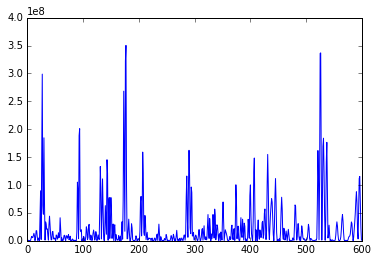

In [198]:
plt.plot(np.mean(w2,axis=-1))

In [195]:
wvlt2 = w2[:dw]

In [196]:
# Old and wrong
# Auto correlation
w22 = np.correlate(s_crop, s_crop, mode='full')

ValueError: object too deep for desired array

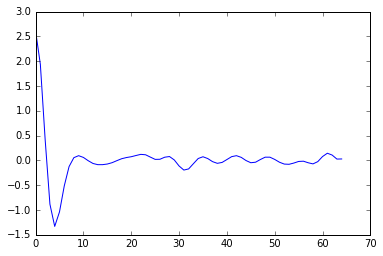

In [197]:
plt.plot(w22[dn-1:dn+dw])

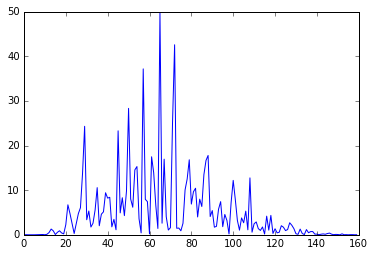

In [107]:
plt.plot(abs(fft(w2))[:160])

# Wavelet estimation by spectral division

In [118]:
def smooth(x,window_len=11,window='hanning'):
  
    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
    
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y 

In [140]:
r_crop = r[n1:n1+dn]

In [119]:
S = fft(s_crop)
R = fft(r_crop)

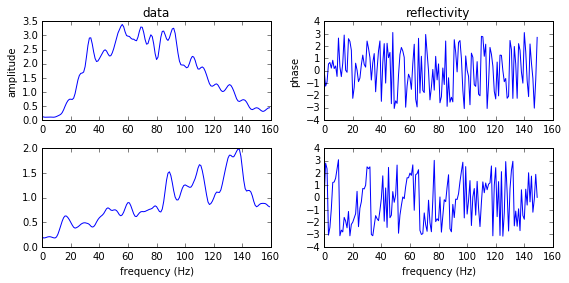

In [120]:
f = plt.figure(figsize=(8,4))

a, b = 0, len(S)//4

ax11 = f.add_subplot(221)
ax11.plot(smooth(abs(S[a:b])))
ax11.set_ylabel('amplitude')
ax11.set_title('data')

ax12 = f.add_subplot(223)
ax12.plot(smooth(abs(R[a:b])))
ax12.set_xlabel('frequency (Hz)')

ax21 = f.add_subplot(222)
ax21.plot(np.angle(S[a:b]))
ax21.set_ylabel('phase')
ax21.set_title('reflectivity')
ax22 = f.add_subplot(224)
ax22.plot(np.angle(R[a:b]))
ax22.set_xlabel('frequency (Hz)')
f.tight_layout()

We can't divide things by zero, so for band-limited stuff, Fourier components are zero
in the case of well logs we can divide by the reflectivity in the Fourier domain

In [124]:
W = S / R
w3 = ifft(W)

/Users/Evan/anaconda/lib/python3.4/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


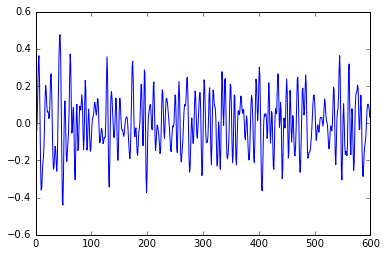

In [125]:
plt.plot(w3)

# Wavelet estimation by least squares

Wiener Filter method (?)

In [48]:
def opConvolve(data, kernel_size):
    op = np.zeros((data.size-kernel_size+1, kernel_size))
    for i in range(data.size-kernel_size):
        op[i, :] = data[i:i+kernel_size]
    return op

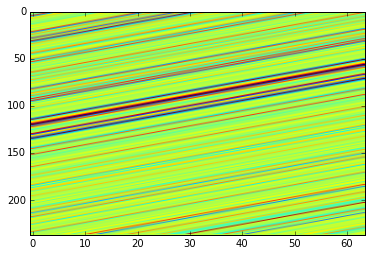

In [49]:
C = opConvolve(np.transpose(r_crop), dw)
plt.imshow(C, aspect='auto')

In [50]:
from numpy.linalg import solve, lstsq
s_inv = s_crop[dw//2:-dw//2+1]

w4 = lstsq(C, s_inv)[0]

# Plot wavelets

/Users/Evan/anaconda/lib/python3.4/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


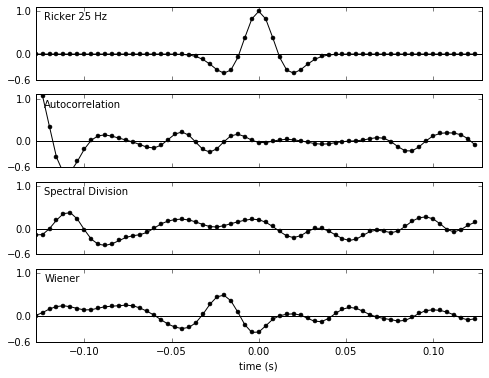

In [51]:
### Two subplots, the axes array is 1-d
wavelets = [w1, w2[:64], w3[:64], w4]
labels = ['Ricker 25 Hz', 'Autocorrelation', 'Spectral Division', 'Wiener']
f, axarr = plt.subplots(len(wavelets), sharex=True,figsize=(8,6))
for i, w in enumerate(wavelets):
    xlabel = False
    if i==len(wavelets)-1:
        xlabel = True
    plot_wavelet(axarr[i],w,tw, xlabel=xlabel, points=True, label=labels[i])
    

# Power spectra of our wavelets

In [248]:
# do that here

# Correlations

In [249]:
s1 =  np.convolve(w1, r, mode='same')  # visual
s2 =  np.convolve(w2, r, mode='same')  # autocorrelation
s3 =  np.convolve(w3, r, mode='same')  # spectral division
s4 =  np.convolve(w4, r, mode='same')  # spectral division
#s4 = np.dot(C, w4) # least squares

In [250]:
def plot_traces(ax, data, tbase, ntraces=3, gain=1, dtr = 1.0, xlim=(-1.0,0), ylim=(0,3.0), ylabel=False, norm=True, points=False):
    if points:
        point = 'ko-'
    else:
        point = 'k'
    for i in range(ntraces):
        ax.plot(dtr*i + gain*data, tbase, point, ms=ms)
        ax.fill_betweenx(tbase, dtr*i + gain*data,  dtr*i, data > 0.0,  color='k', alpha = 1.0)

        #ax.axvline(dtr*i, color='k', lw=0.5)
    ax.set_xlim((xlim[0],xlim[1]+ntraces))
    ax.set_ylim((ylim[0],ylim[1]))
    ax.invert_yaxis()
    if ylabel:
        ax.set_ylabel('time (s)')
    ax.set_xticks([])
    #ax.axis('off')
    return ax

# Get some tops for reference

In [251]:
tops = {'Abenaki': 2.464481997278976,
 'Base O-Marker': 1.9831661738768789,
 'Dawson Canyon': 1.0092858736127031,
 'L Baccaro': 2.7125863889183219,
 'L Missisauga': 2.361502648983643,
 'Logan Canyon': 1.1345061376197538,
 'Mid Baccaro': 2.4982437733593552,
 'U Missisauga': 1.869903991252488,
 'Wyandot': 0.92197301601869186}

corr start time:  1.48
corr end time:  2.68


/Users/Evan/anaconda/lib/python3.4/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Evan/anaconda/lib/python3.4/site-packages/matplotlib/axes/_axes.py:4794: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[1:N + 1, 0] = x1slice


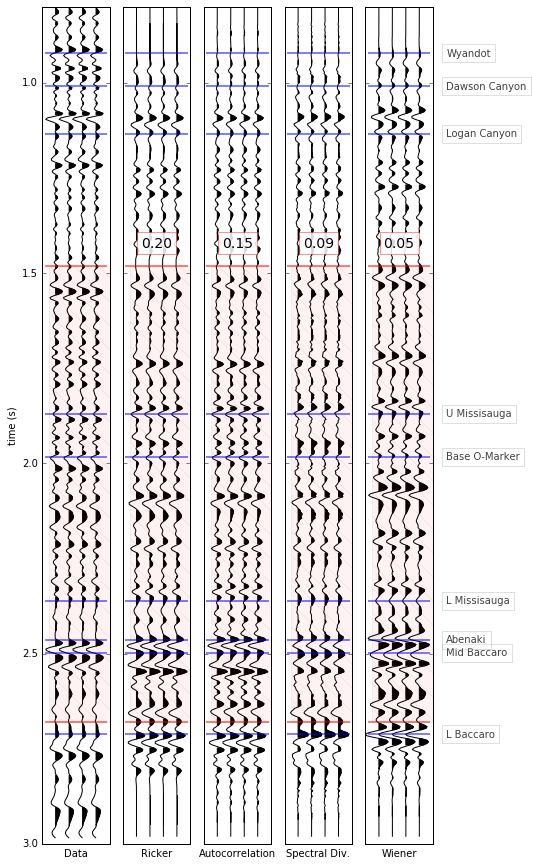

In [256]:
# Plot params

top_t = 0.8  # start time of plot
base_t = 3.0  # end time of plot
lag = 3
traces = [norm(s[lag:]), s1[:-lag], s2[:-lag], s3[:-lag], s4[:-lag]]
trace_labels = ['Data', 'Ricker', 'Autocorrelation', 'Spectral Div.', 'Wiener']
scalar = 0.75
gain = scalar*np.array([3, 1, 1, 1, 1])

# Correlation params
c1 = n1  # sample number to start correlation
c2 = dn  # length of window for correlation
print ('corr start time: ', c1*dt)
print ('corr end time: ', dt*(c1+c2))
ccff = []
for signal in traces[1:]:
    ccff.append(np.corrcoef(abs(traces[0])[c1:c1+c2],abs(signal)[c1:c1+c2])[0][1])

f, axarr = plt.subplots(1,len(traces), sharey=True,figsize=(7,15))
for i, d in enumerate(traces):
    ylabel = False
    if i==0:
        ylabel = True
    plot_traces(axarr[i],norm(d),np.arange(0,len(d),1)*dt, ntraces=4,
                gain = gain[i],
                ylabel=ylabel, 
                norm=False)
    axarr[i].set_xlabel(trace_labels[i])
    axarr[i].set_ylim((base_t,top_t))
    
    for name, twt in tops.items():
        axarr[i].axhline(y = float(twt), color = 'b', lw = 2, 
                         alpha = 0.5, xmin = 0.05, xmax = 0.95)
        if i == len(traces)-1:
            axarr[i].text(x = 5, y = float(twt), s = name,
                      alpha=0.75, color='k',
                      fontsize = '10',
                      horizontalalignment = 'left',
                      verticalalignment = 'center',
                      bbox=dict(facecolor='white', alpha=0.25, lw = 0.5),
                      weight = 'light')
            
    axarr[i].add_patch(patches.Rectangle((-0.5, c1*dt),5.5,c2*dt, hatch='\\', alpha=0.05, fc='r'))

    axarr[i].axhline(y = c1*dt, color = 'r', lw = 2, 
                    alpha = 0.5, xmin = 0.05, xmax = 0.95)
    axarr[i].axhline(y = (c1+c2)*dt, color = 'r', lw = 2, 
                    alpha = 0.5, xmin = 0.05, xmax = 0.95)
    if i != 0:
        axarr[i].text(x = 1.5, y = (c1-10)*dt, s = "{:.2f}".format(ccff[i-1]),
                      alpha=1.0, color='k',
                      fontsize = '14',
                      horizontalalignment = 'center',
                      verticalalignment = 'bottom',
                      bbox=dict(facecolor='white', ec='r', alpha=0.85, lw = 0.5),
                      weight = 'normal')
        
    
    